# **Set Up Environment**

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder
from torchvision import datasets, transforms, models
from torch.utils.data import DataLoader, Dataset
from PIL import Image
import os
import torch

# **Load Data**

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
transform = transforms.Compose([
    transforms.Resize((300, 300)),
    transforms.ToTensor(),
])

train_dataset = datasets.ImageFolder(root='/content/drive/MyDrive/Colab Notebooks/ProjectML/data/train', transform=transform)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=False)


selected_classes = train_dataset.classes

class CustomValDataset(Dataset):
    def __init__(self, img_dir, annotations_df, transform=None):
        self.img_dir = img_dir
        self.transform = transform
        self.data = annotations_df

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        img_name = self.data.iloc[idx, 0]
        label = self.data.iloc[idx, 1]
        img_path = os.path.join(self.img_dir, img_name)
        image = Image.open(img_path).convert("RGB")
        if self.transform:
            image = self.transform(image)
        return image, label

annotations_path = '/content/drive/MyDrive/Colab Notebooks/ProjectML/data/val/val_annotations.txt'
annotations_df = pd.read_csv(annotations_path, sep='\t', header=None)
annotations_df.columns = ['image', 'class', 'x1', 'y1', 'x2', 'y2']
filtered_val_df = annotations_df[annotations_df['class'].isin(selected_classes)][['image', 'class']]

val_dataset = CustomValDataset('/content/drive/MyDrive/Colab Notebooks/ProjectML/data/val/images', filtered_val_df, transform=transform)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
resnet = models.resnet18(pretrained=True)
resnet = torch.nn.Sequential(*list(resnet.children())[:-1])
resnet.to(device)
resnet.eval()

def extract_features(dataloader, is_val=False):
    features = []
    labels = []

    with torch.no_grad():
        for imgs, lbls in dataloader:
            imgs = imgs.to(device)
            feats = resnet(imgs).squeeze()
            features.append(feats.cpu().numpy())

            if is_val:
                labels.extend(lbls)
            else:
                labels.extend([train_dataset.classes[i] for i in lbls])

    return np.vstack(features), np.array(labels)

X_train, y_train = extract_features(train_loader)
X_test, y_test = extract_features(val_loader, is_val=True)

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


# **K-nearest Neighbor (KNN)**

In [ ]:
# define the grid of k values you want to try
param_grid = {'n_neighbors': [2, 4, 6, 8]}

# set up the base estimator and grid search
knn = KNeighborsClassifier()
grid = GridSearchCV(
    estimator=knn,
    param_grid=param_grid,
    scoring='accuracy',
    cv=5,
    n_jobs=-1,
    verbose=1
)

# run grid search
grid.fit(X_train, y_train)

# best parameters & CV score
best_k    = grid.best_params_['n_neighbors']
best_cv   = grid.best_score_
print(f"\nBest k : {best_k}  with accuracy = {best_cv * 100:.3f}%")

# evaluate this best‐k model on your validation set
knn_best   = grid.best_estimator_

Fitting 5 folds for each of 4 candidates, totalling 20 fits

Best k : 8  with accuracy = 80.840%


Accuracy for k=6: 80.800%
              precision    recall  f1-score   support

   n01443537       0.84      0.84      0.84        50
   n02410509       0.81      0.94      0.87        50
   n03977966       0.96      0.98      0.97        50
   n07715103       0.73      0.76      0.75        50
   n07747607       0.82      0.62      0.70        50
   n07768694       0.87      0.68      0.76        50
   n07873807       0.79      0.82      0.80        50
   n07920052       0.89      0.94      0.91        50
   n09256479       0.70      0.94      0.80        50
   n12267677       0.70      0.56      0.62        50

    accuracy                           0.81       500
   macro avg       0.81      0.81      0.80       500
weighted avg       0.81      0.81      0.80       500



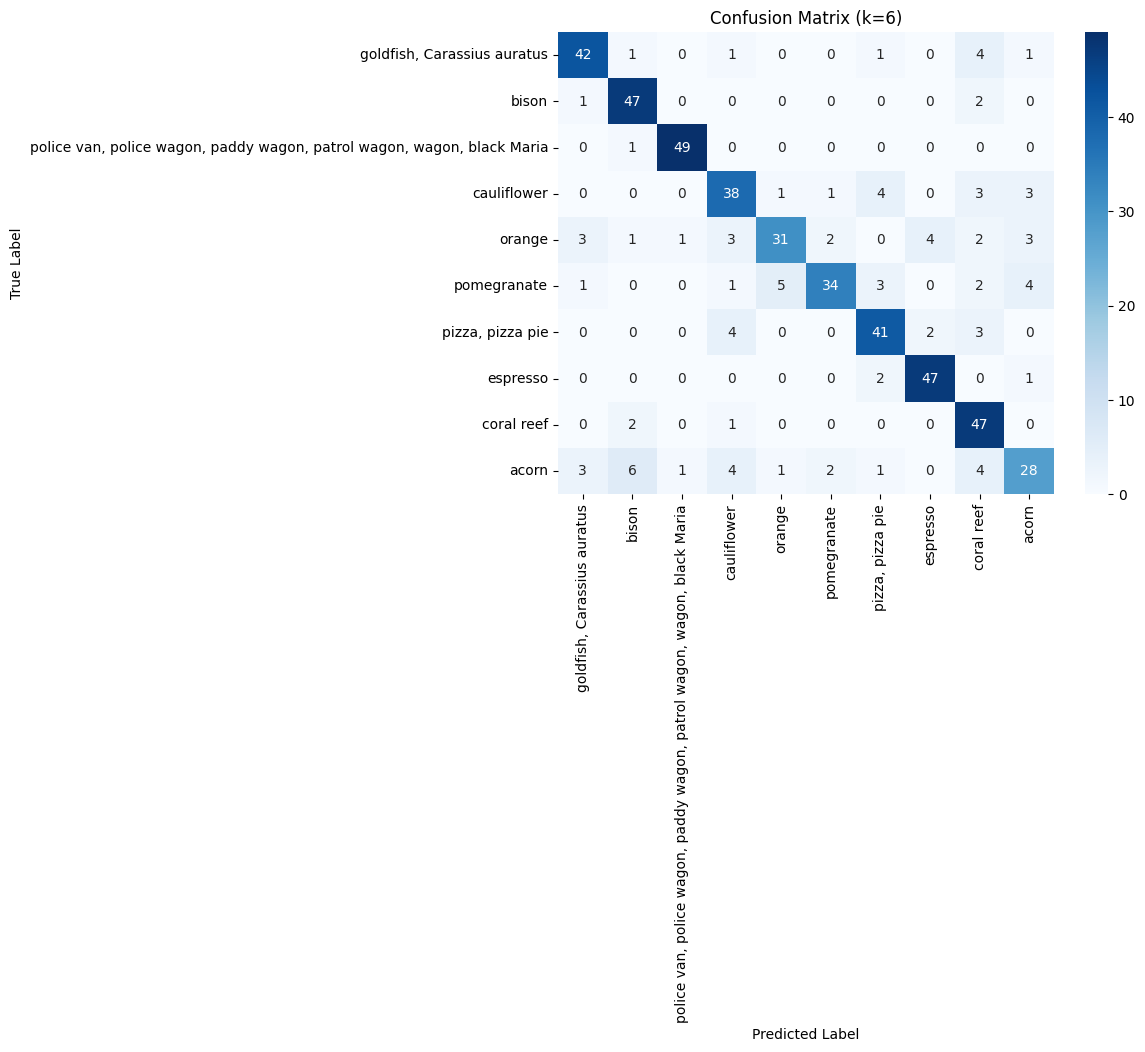


 -+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-
Accuracy for k=7: 81.400%
              precision    recall  f1-score   support

   n01443537       0.84      0.82      0.83        50
   n02410509       0.82      0.94      0.88        50
   n03977966       0.96      0.98      0.97        50
   n07715103       0.76      0.76      0.76        50
   n07747607       0.85      0.66      0.74        50
   n07768694       0.89      0.68      0.77        50
   n07873807       0.79      0.82      0.80        50
   n07920052       0.87      0.94      0.90        50
   n09256479       0.69      0.96      0.80        50
   n12267677       0.72      0.58      0.64        50

    accuracy                           0.81       500
   macro avg       0.82      0.81      0.81       500
weighted avg       0.82      0.81      0.81       500



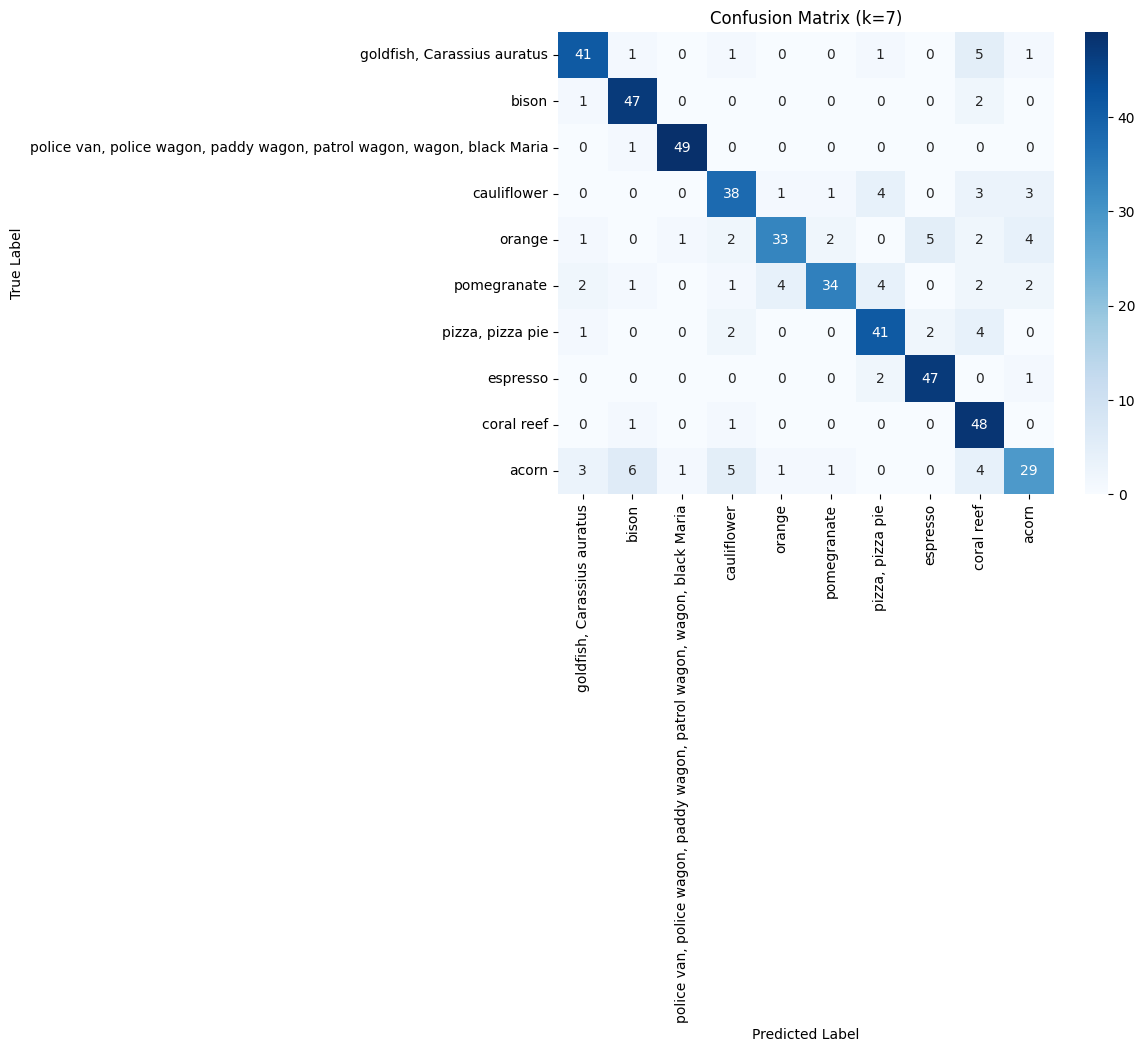


 -+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-
Accuracy for k=8: 80.800%
              precision    recall  f1-score   support

   n01443537       0.83      0.80      0.82        50
   n02410509       0.82      0.94      0.88        50
   n03977966       0.96      0.98      0.97        50
   n07715103       0.81      0.76      0.78        50
   n07747607       0.80      0.64      0.71        50
   n07768694       0.89      0.64      0.74        50
   n07873807       0.79      0.84      0.82        50
   n07920052       0.85      0.94      0.90        50
   n09256479       0.68      0.94      0.79        50
   n12267677       0.68      0.60      0.64        50

    accuracy                           0.81       500
   macro avg       0.81      0.81      0.80       500
weighted avg       0.81      0.81      0.80       500



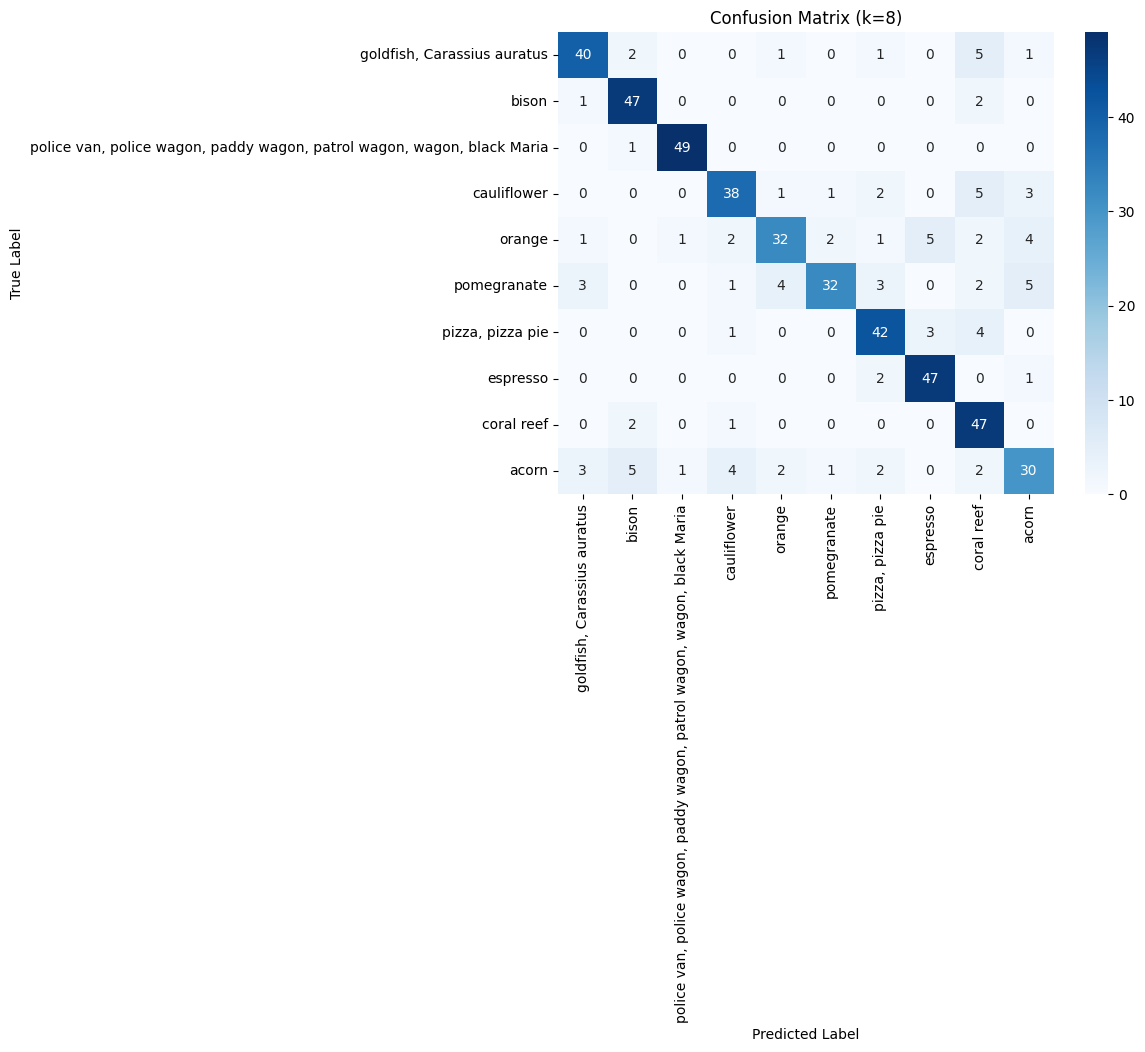


 -+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-
Accuracy for k=9: 80.200%
              precision    recall  f1-score   support

   n01443537       0.87      0.82      0.85        50
   n02410509       0.81      0.92      0.86        50
   n03977966       0.96      0.98      0.97        50
   n07715103       0.86      0.72      0.78        50
   n07747607       0.76      0.62      0.68        50
   n07768694       0.86      0.64      0.74        50
   n07873807       0.84      0.86      0.85        50
   n07920052       0.85      0.94      0.90        50
   n09256479       0.62      0.96      0.76        50
   n12267677       0.67      0.56      0.61        50

    accuracy                           0.80       500
   macro avg       0.81      0.80      0.80       500
weighted avg       0.81      0.80      0.80       500



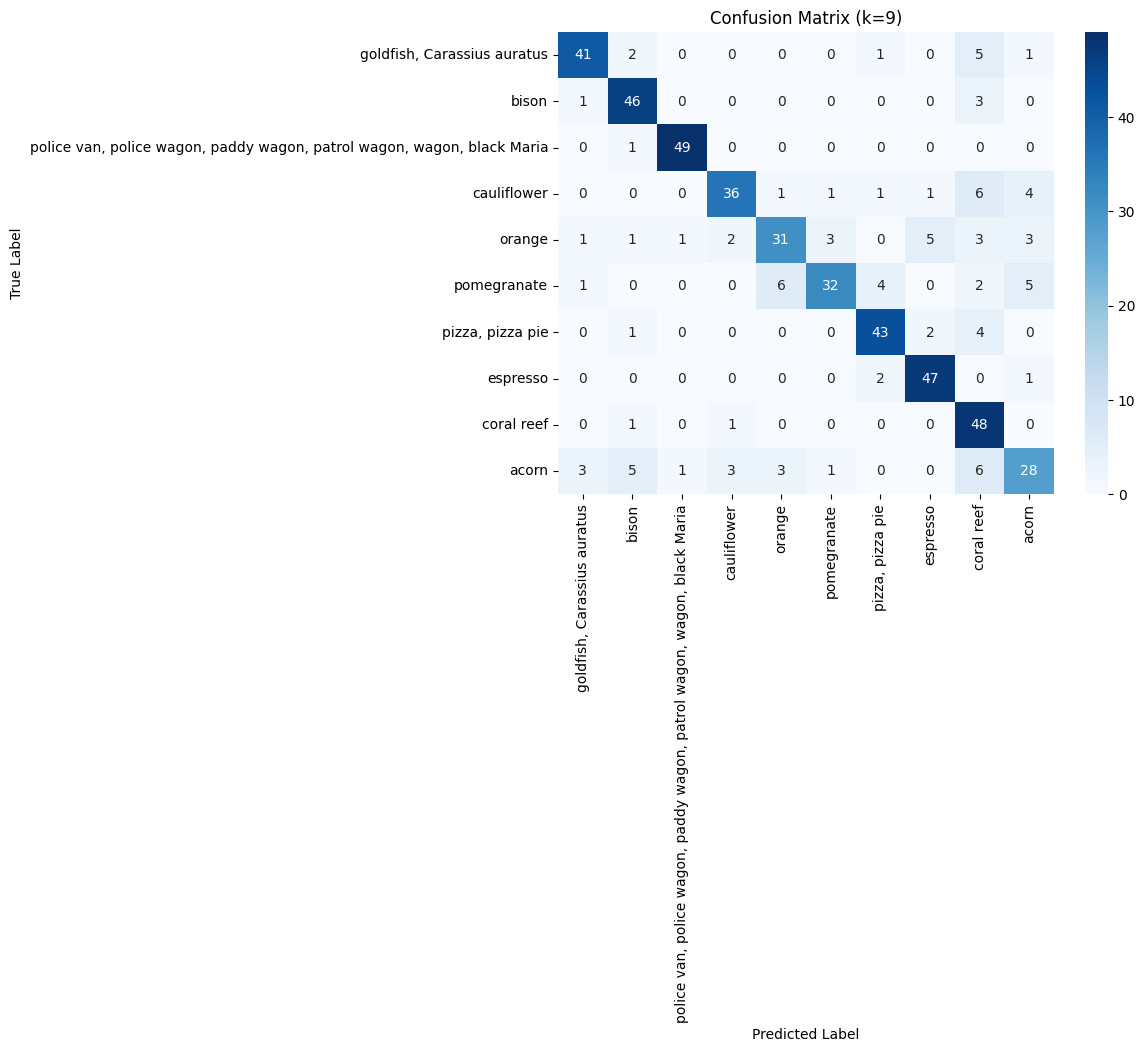


 -+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-


In [ ]:
# Find the real names of the corresponded IDs
words_df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/ProjectML/data/words.txt', sep='\t', header=None, names=['id', 'label'])
id_to_name = dict(zip(words_df['id'], words_df['label']))
labels = sorted(np.unique(np.concatenate([y_train, y_test])))
labels = [id_to_name[label_id] for label_id in labels]

no_neighbors = [6, 7, 8, 9]

for k in no_neighbors:

    # Train the Model
    knn = KNeighborsClassifier(k)
    knn.fit(X_train, y_train)

    # Make Predictions
    y_pred = knn.predict(X_test)

    # Calculate accuracy
    accuracy = accuracy_score(y_test, y_pred)
    print(f"Accuracy for k={k}: {accuracy * 100:.3f}%")

    # Classification Report
    report = classification_report(y_test, y_pred)
    print(report)

    # Confusion matrix
    conf_matrix = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=labels, yticklabels=labels)
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.title(f"Confusion Matrix (k={k})")
    plt.show()

    print("\n -+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-")